## Additional information on different types of regressions

*IMPORTANT: The discussions about different types of models are a lot more complex than what we're showing below. These steps are only valid for the Digital Analytics course, and as a preliminary set of steps so you can explore statistical modelling beyond linear and logistic regressions. For your thesis (or other work for the master), please follow the general instructions from the methods courses.*

In DA5, we have applied two different types of regression analysis: linear and logistic regression models. As you know from your statistics classes, each model has a number of assumptions and requirements for the data. Regarding the data, one of the assumptions of logistic regression is that it assumes you dependent variable to be binary. For linear regression, your dependent variable should be normally distributed. However, when you look at a lot of digital trace data, it is not true.

For example, think about Twitter data. Imagine that I want to investigate what drives likes for tweets about surveillance and my research question is 
"To what extent is the mention of digital media tech companies in a tweet related to the number of likes of the tweet?"

Let's start with opening the data and having a look at the variables.


In [76]:
import pandas as pd
import seaborn as sns

In [132]:
df = pd.read_pickle('twitter_sentiment_mini.pkl')

In [133]:
df.head()

,id,text,metric_retweet_count,metric_followers_count,metric_like_count,pseudID,positive,negative,neutral,is_retweet,digi_media_tech,usa,eu,country
0,1438405320204853248,“conspiracy practices —the methods by which tr...,0,879,0,2,2,-2,-1,0,0,0,0,none
1,1438405307693027328,@mention Have you done any work to estimate th...,0,230,0,3,1,-1,0,0,0,0,0,none
2,1438405226801807364,"📝We have examined the design, implementation a...",0,12992,0,5,2,-3,-1,0,0,0,0,none
3,1438405184544067589,"first time trying out the #sarkargame. and, it...",0,197,0,6,2,-4,-1,0,0,0,0,none
4,1438404847406100481,We're set up and ready here at @mention #OPSEC...,0,2418,0,15,2,-1,1,0,0,0,0,none


In [134]:
df['metric_retweet_count'].describe()

count    16951.000000
mean         2.325703
std         20.558799
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        874.000000
Name: metric_retweet_count, dtype: float64

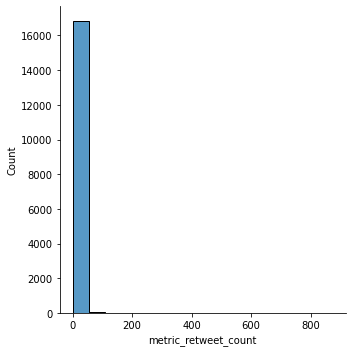

In [135]:
sns.displot(x='metric_retweet_count', data = df)

As you can see, our dependent variable takes values between 0 and 874 and is not normally distributed. This makes sense as most tweets do not get retweets. This means that we violate one of the assumptions of linear regression. We can apply a linear regression model and keep in mind that the results might not be fully reliable or look for a model that does not have such an assumption. There are many different models that we can fit to our data and in this additional tutorial we will introduce you to one of them, namely Poisson regression.

### What is Poisson regression?

Poisson regression is a model that assumes that your dependent variable are counts following a Poisson distribution. A count variable is discrete variable that consists of non-negative integers. It counts occurences of an event (how often did purchase happen, how many times a person visited the shop, how many times a tweet got retweeted - such counts of events cannot be negative and are always 0 or above). 

Often rare events follow Poisson distribution. In case of tweets, retweets are rather rare so when we want to count how often they occur, we end up with such distribution. This is the case with a lof of digital trace data that counts events for example how many purchases are done in a week or how many people click on an ad in a day.

When working with such data, we can hence decide to apply a Poisson regression model to account for the fact that 0 is very often present in the dependent variable. Let's see how we can do it in Python.

Our variables are as follows:
* IV: mention of digital media tech
* DV: number of retweets
* Control: sentiment

Let's start with exploring data and seeing if we have all necessary variables.

In [146]:
df.dtypes

id                         int64
text                      object
metric_retweet_count       int64
metric_followers_count     int64
metric_like_count          int64
pseudID                   object
positive                  object
negative                  object
neutral                   object
is_retweet                 int64
digi_media_tech            int64
usa                        int64
eu                         int64
country                   object
dtype: object

It looks like an overall measure for sentiment (our control variable) is missing and that we need to change data types for sentiment scores.

In [147]:
df['positive'] = df['positive'].apply(pd.to_numeric)
df['negative'] = df['negative'].apply(pd.to_numeric)

df['sentiment'] = df['positive'] + df['negative']

Let's start with creating the model using statsmodels.

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [149]:
#Note that the code is similar but we use a different type of models - Generalized Linear Model
poisson_model = sm.GLM(df['metric_retweet_count'], sm.add_constant(df[['sentiment', 'digi_media_tech']]), family = sm.families.Poisson())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [150]:
result = poisson_model.fit()

In [151]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     metric_retweet_count   No. Observations:                16951
Model:                              GLM   Df Residuals:                    16948
Model Family:                   Poisson   Df Model:                            2
Link Function:                      log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:            -1.2752e+05
Date:                  Thu, 06 Oct 2022   Deviance:                   2.4307e+05
Time:                          12:41:48   Pearson chi2:                 2.87e+06
No. Iterations:                       8                                         
Covariance Type:              nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.7117      0.006    117.931      0.000       0.700       0.724
sentiment          -0.1439      0.004    -33.956      0.000      -0.152      -0.136
digi_media_tech     0.9792      0.020     49.165      0.000       0.940       1.018
===================================================================================
"""

How can we interpret the output? The Pearson statistic provides an estimate of the data’s dispersion. The model assums that the data is dispersed meaning that the variance of the dependent variable is similar to the mean. If that is not the case, the model will not fit well. We can check it by dividing Pearsons chi2 by residual degrees of freedom (Df Residuals) - if that is much larger than 1, the model is overdispersed meaning it has too great variability for the model. If the result is much smaller than 1, the data is underdispersed meaning it has too little variability. 

As you can see below, our data shows overdispertion. This means that this model does not fit well and we cannot make conclusions about the data from it (similar to when a linear regression model is not significant).

Regarding interpretation of the coefficients, they are log of expected counts. What does it mean? When we look at our binary independent variable,  it is positive, meaning  we consider two tweets, one with and one without the companies mentioned, with identical sentiment, the tweet with digital media tech mentioned  will have a higher predicted value of log(# retweets) than the tweet without the mention. Thus, we would expect the tweet mentioning digital media tech to have more retweets than a tweet without. For a continous predictor sentiment was can say that if a tweet is more negative by 1 score on the scale, the difference in the logs of expected counts would be expected to decrease by -0.14. If we consider two tweets with the same score on digit_media_tech, we would expect the tweet with the higher sentiment of the two to have less retweets than the other tweet.

In [161]:
#Calculating model fit
2.87e+06/16948

169.34151522303517

We can also use Poisson model for making preditions.

In [162]:
from sklearn.linear_model import PoissonRegressor
import numpy

In [163]:
model = PoissonRegressor()

In [164]:
model.fit(df[['sentiment', 'digi_media_tech']], df['metric_retweet_count'])

PoissonRegressor()

In [160]:
model.predict([[-4,0]])

array([3.38105473])

In [166]:
model.predict([[-4,1]])

array([3.70411151])

Poisson models are only one example of models that can be useful when working with digital trace data. Another example is Negative Binominal Regression (also available in statsmodels in Python). That model also does not assume a normal distribution, but similarly can be used to model rare events especially when they are overdispersed. This means it is applicable to data that has a lot of cases with 0 occurrences, but still quite some variation in the number of occurrences. If you are interested in different models, have a look at the documentation to explore how to best model your data.